In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, FloatSlider, IntSlider
from scipy.signal import chirp

In [3]:
## Parameters
C = 3 * 10**8    # Speed of light

L = 100          # Length of target strip
B = 100          # Width of target strip

v = 100          # Velocity of the sensor (m/s)
beta = 40        # Grazing Angle (degrees)
omega = 20       # Integration Angle (degrees)
h = 10000        # Height of sensor from ground (m)
max_h = 0        # Maximum height capturable by sensor (m)
PRI = 1/2000     # Pulse Repetition Interval (Hz)

x_t = 0         # Target x-coordinate
y_t = 0         # Target y-coordinate
z_t = 50         # Target z-coordinate

In [4]:
# Derived parameters
omega = math.radians(omega)
beta = math.radians(beta)

y_c = h / math.tan(beta)   # Horizontal distance to the origin of target strip
d_c = h / math.sin(beta)   # Slant distance to the origin of target strip

delta_min = - y_c * math.tan(0.5 * omega)       # Maximum negative distance deviation from APC 
delta_max = y_c * math.tan(0.5 * omega)         # Maximum positive distance deviation from APC

num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

In [5]:
# Function to calculate distance deviation of current sensor based on sample index
cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

# Function to calculate slant distance of the target from the current sensor position
cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   

# Assume that the distance deviation of sensor when it emit and receive signal is neglible
cal_time_pulse = lambda distance : 2 * (distance / C)
cal_distance_from_time = lambda pulse_time : pulse_time * C * 0.5 

# Get near and far range time (to gate)
near_range_time = cal_time_pulse(
        math.sqrt((max(0, h - max_h))**2 + (y_c - B/2.0)**2)
    )
far_range_time = cal_time_pulse(
        math.sqrt((math.sqrt((delta_max + L/2.0)**2 + (y_c + B/2.0)**2))**2 + h**2)
    )

In [6]:
time_result = []

for i in range(math.floor(num_of_samples)):
    dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
    target_slant_distance = cal_target_slant_distance(dist_deviation)   
    time_pulse = cal_time_pulse(target_slant_distance)
    time_result.append(time_pulse)

time_result = np.array(time_result)

# Halved to get the distance to the target
distance_result = cal_distance_from_time(time_result)    

print( f"near range time: {near_range_time}")
print( f"far range time: {far_range_time}")
print( f"number of samples {math.floor(num_of_samples)}")
print( f"resulting pulse time: {time_result}")

near range time: 0.00010345979550928658
far range time: 0.0001049550942068235
number of samples 84055
resulting pulse time: [0.00010444 0.00010444 0.00010444 ... 0.00010444 0.00010444 0.00010444]


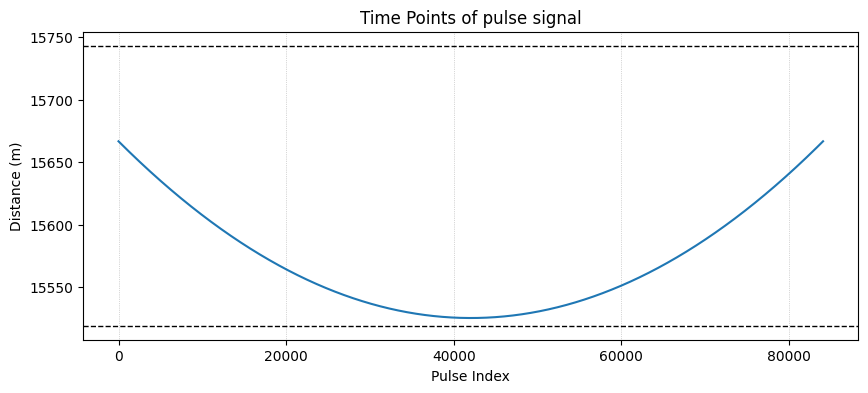

In [7]:
# Plot of pulse time
plt.figure(figsize=(10, 4))


plt.plot(distance_result) # Plot of distance to pulse index
plt.ylabel("Distance (m)")
plt.xlabel("Pulse Index")
plt.axhline(cal_distance_from_time(near_range_time), color='black', linestyle='--', linewidth=1)
plt.axhline(cal_distance_from_time(far_range_time), color='black', linestyle='--', linewidth=1)
plt.title("Time Points of pulse signal")
plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
plt.show()

## Simulate Pulse
This is an interactive simulation of the distance a signal travels if a sensor is assumed to be moving horizontally in the azimuth

In [8]:
def simulate_time_result(light_speed: float = 3e8, 
                         azimuth_length: float = 100.0, 
                         range_width: float = 100.0, 
                         sensor_speed: float = 100.0, 
                         grazing_angle_deg: float = 40.0,
                         integration_angle_deg: float = 20.0,
                         sensor_height: float = 10000.0,
                         max_capturable_height: float = 0,
                         sampling_frequency: float = 2000,
                         target_x: float = 0,
                         target_y: float = 0,
                         target_z: float = 50):

    # Derived parameters
    integration_angle_rad = math.radians(integration_angle_deg)
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / sampling_frequency

    y_c = h / math.tan(grazing_angle_rad)   # Horizontal distance to the origin of target strip
    d_c = h / math.sin(grazing_angle_rad)   # Slant distance to the origin of target strip

    delta_min = - y_c * math.tan(0.5 * integration_angle_rad)       # Maximum negative distance deviation from APC 
    delta_max = y_c * math.tan(0.5 * integration_angle_rad)         # Maximum positive distance deviation from APC

    num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

    # Function to calculate distance deviation of current sensor based on sample index
    cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

    # Function to calculate slant distance of the target from the current sensor position
    cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   

    # Assume that the distance deviation of sensor when it emit and receive signal is neglible
    cal_time_pulse = lambda distance : 2 * (distance / C)
    cal_distance_from_time = lambda pulse_time : pulse_time * C * 0.5 

    # Get near and far range time (to gate)
    near_range_time = cal_time_pulse(
            math.sqrt((max(0, h - max_h))**2 + (y_c - B/2.0)**2)
        )
    far_range_time = cal_time_pulse(
            math.sqrt((math.sqrt((delta_max + L/2.0)**2 + (y_c + B/2.0)**2))**2 + h**2)
        )   

    time_result = []

    for i in range(math.floor(num_of_samples)):
        dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
        target_slant_distance = cal_target_slant_distance(dist_deviation)   
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)

    time_result = np.array(time_result)

    # Halved to get the distance to the target
    distance_result = cal_distance_from_time(time_result)   

    # Get Chirp
    # emitted_chirps, received_chirps = simulate_chirp_signal(num_of_samples, time_result, PRI)
    # plot_chirp_signal(emitted_chirps, received_chirps)

    plot_distance_pulse(distance_result, near_range_time, far_range_time)


def plot_distance_pulse(distance_result, near_range_time, far_range_time):
    # Plot of pulse time
    plt.figure(figsize=(10, 4))

    plt.plot(distance_result) # Plot of distance to pulse index
    plt.ylabel("Distance (m)")
    plt.xlabel("Pulse Index")
    plt.axhline(cal_distance_from_time(near_range_time), color='black', linestyle='--', linewidth=1)
    plt.axhline(cal_distance_from_time(far_range_time), color='black', linestyle='--', linewidth=1)
    plt.title("Time Points of pulse signal")
    plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
    plt.show()


def generate_chirp(start_time=0,
                   amplitude=1.0,
                   frequency=1.0,
                   pulse_width=1.0,
                   bandwidth=1.0,
                   sampling_frequency=10000):
    num_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(start_time, start_time + pulse_width, num_samples, endpoint=False)
    gamma = bandwidth / pulse_width
    quadratic_phase = np.pi * gamma * (t - (start_time + pulse_width / 2))**2
    y = amplitude * np.sin(2 * np.pi * frequency * t + quadratic_phase)
    return t, y


def simulate_chirp_signal(num_of_samples, time_result, PRI):
    emitted_chirps = []
    received_chirps = []

    for i in range(math.floor(num_of_samples)):
        current_time = i * PRI     # Each multiple of PRI indicates a new emitted chirp signal
        
        # Simulate emitted signal
        t_emit, tx_signal_emit = generate_chirp(current_time,
                                        amplitude=1.0,
                                        frequency=5,
                                        pulse_width=6.0,
                                        bandwidth=10.0,
                                        sampling_frequency=1000)

        # Simulate received signal
        t_recv, tx_signal_recv = generate_chirp(current_time+time_result[i],
                                        amplitude=1.0,
                                        frequency=5,
                                        pulse_width=6.0,
                                        bandwidth=10.0,
                                        sampling_frequency=1000)

        emitted_chirps.append((t_emit, tx_signal_emit))
        received_chirps.append((t_recv, tx_signal_recv))

    return emitted_chirps, received_chirps


# def plot_chirp_signal(emitted_chirps, received_chirps, sample_limit=5):
#     plt.figure(figsize=(12, 6))

#     for i in range(min(sample_limit, len(emitted_chirps))):
#         t_e, y_e = emitted_chirps[i]
#         t_r, y_r = received_chirps[i]

#         plt.plot(t_e, y_e, label=f'Emit #{i}', alpha=0.7)
#         plt.plot(t_r, y_r, label=f'Recv #{i}', linestyle='--', alpha=0.7)

#     plt.xlabel("Time [s]")
#     plt.ylabel("Amplitude")
#     plt.title("Overlay of Emitted and Received Chirp Signals")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
 


In [9]:
sliders = {
    "azimuth_length": FloatSlider(min=10.0, max=1000.0, step=0.1, value=100.0),
    "range_width": FloatSlider(min=10.0, max=1000.0, step=0.1, value=100.0),
    "sensor_speed": FloatSlider(min=10.0, max=500, step=0.1, value=100.0),
    "grazing_angle_deg": FloatSlider(min=0.1, max=90, step=0.1, value=40.0),
    "integration_angle_deg": FloatSlider(min=0, max=180, step=0.1, value=20.0),
    "sensor_height": FloatSlider(min=100, max=1000000, step=0.1, value=10000.0),
    "max_capturable_height": FloatSlider(min=0, max=1000, step=0.1, value=0),
    "sampling_frequency": IntSlider(min=1, max=5000, step=1, value=2000)
}
sliders["target_x"] = FloatSlider(min=-sliders["azimuth_length"].value/2, 
                                  max=sliders["azimuth_length"].value/2, 
                                  step=0.1, 
                                  value=0.0)
sliders["target_y"] = FloatSlider(min=-sliders["range_width"].value/2, 
                                  max=sliders["range_width"].value/2, 
                                  step=0.1, 
                                  value=0.0)
sliders["target_z"] = FloatSlider(min=0, 
                                  max=sliders["max_capturable_height"].value, 
                                  step=0.1, 
                                  value=0.0)

def update_target_x_slider_range(change):
    sliders["target_x"].min = change['new']/2
    sliders["target_x"].max = change['new']/2
    if sliders["target_x"].value > sliders["target_x"].max:
        sliders["target_x"].value = sliders["target_x"].max
    if sliders["target_x"].value < sliders["target_x"].min:
        sliders["target_x"].value = sliders["target_x"].min

def update_target_y_slider_range(change):
    sliders["target_y"].min = change['new']/2
    sliders["target_y"].max = change['new']/2
    if sliders["target_y"].value > sliders["target_y"].max:
        sliders["target_y"].value = sliders["target_y"].max
    if sliders["target_y"].value < sliders["target_y"].min:
        sliders["target_y"].value = sliders["target_y"].min

def update_target_z_slider_range(change):
    sliders["target_z"].max = change['new']
    if sliders["target_z"].value > sliders["target_z"].max:
        sliders["target_z"].value = sliders["target_z"].max

sliders["azimuth_length"].observe(update_target_x_slider_range, names="value")
sliders["range_width"].observe(update_target_y_slider_range, names="value")
sliders["max_capturable_height"].observe(update_target_z_slider_range, names="value")


def plot_distance_interactive(
                         azimuth_length,
                         range_width,
                         sensor_speed,
                         grazing_angle_deg,
                         integration_angle_deg,
                         sensor_height,
                         max_capturable_height,
                         sampling_frequency,
                         target_x,
                         target_y,
                         target_z):
    simulate_time_result(3e8, azimuth_length, range_width,
                         sensor_speed, grazing_angle_deg, integration_angle_deg,
                         sensor_height, max_capturable_height, sampling_frequency,
                         target_x, target_y, target_z)


ui = interactive(plot_distance_interactive, **sliders)
display(ui)

interactive(children=(FloatSlider(value=100.0, description='azimuth_length', max=1000.0, min=10.0), FloatSlide…

## Simulation of the pulse in time domain for a target

In [156]:
def plot_chirp_sinusoid(amplitude=1.0, 
                        frequency=1.0, 
                        pulse_width=1.0, # The total time of a pulse
                        bandwidth=1.0,
                        sampling_frequency=10000, 
                        axis_limit=2):
    
    # Plot time axis starts from 0 as per time domain
    t = np.linspace(0, axis_limit * np.pi, sampling_frequency)

    gamma = bandwidth/pulse_width     # A constant 
    quadratic_phase = np.pi * gamma * (t - pulse_width/2)**2 # quadratic phase shift required for chirp

    y = amplitude * np.sin( 2 * np.pi * frequency * t + quadratic_phase)

    # Plot of chirp wave
    plt.figure(figsize=(10, 4))
    plt.plot(t, y, label=f'{amplitude} sin(2* pi * {frequency}t + {quadratic_phase[0]})')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title('Sinusoidal Wave')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()



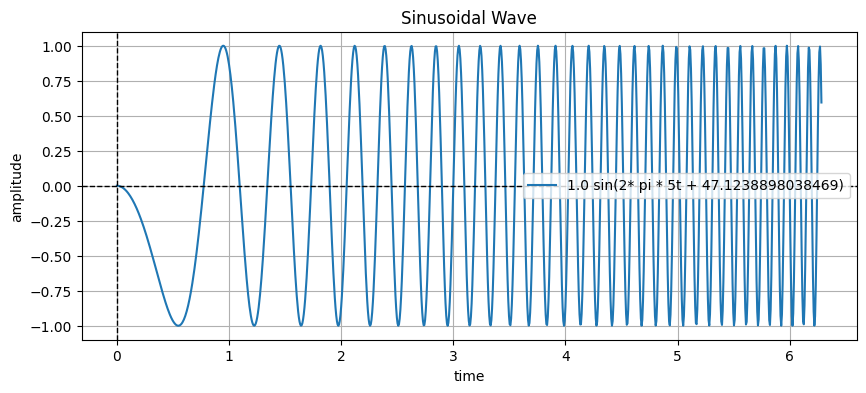

In [157]:
amplitude = 1.0
frequency = 5
pulse_width = 6.0
bandwidth = 10.0
sampling_frequency = 1000
axis_limit = 2
plot_chirp_sinusoid(amplitude,
                    frequency, 
                    pulse_width,
                    bandwidth, 
                    sampling_frequency, 
                    axis_limit)

In [ ]:
def generate_chirp(amplitude=1.0, frequency=1.0, pulse_width=1.0, bandwidth=1.0, sampling_frequency=10000, axis_limit=2):
    t = np.linspace(0, axis_limit * np.pi, sampling_frequency)
    gamma = bandwidth / pulse_width
    quadratic_phase = np.pi * gamma * (t - pulse_width/2)**2
    y = amplitude * np.sin(2 * np.pi * frequency * t + quadratic_phase)
    return t, y

def simulate_received_signal(chirp_signal, delay_samples, attenuation=1.0):
    padded = np.concatenate([np.zeros(delay_samples), attenuation * chirp_signal])
    return padded[:len(chirp_signal)]  # Truncate to original length

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Chirp generation
t, tx_signal = generate_chirp(amplitude=1.0, frequency=5, pulse_width=1, bandwidth=100, sampling_frequency=2000, axis_limit=2)
print(t)
print(tx_signal)


# # 3. Generate received signal
# rx_signal = simulate_received_signal(tx_signal, delay_samples, attenuation=0.8)

# # 4. Plot both signals
# plt.figure(figsize=(12, 4))
# plt.plot(t, tx_signal, label='Transmitted Signal')
# plt.plot(t, rx_signal, label='Received Signal', linestyle='--')
# plt.title('Chirp Transmission and Echo')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()


[0.00000000e+00 3.14316424e-03 6.28632847e-03 ... 6.27689898e+00
 6.28004214e+00 6.28318531e+00]
[-4.91096681e-16  7.74297998e-01  9.81201162e-01 ...  7.89940363e-02
 -8.28598196e-01 -8.98141970e-01]
